# Analysis of order of contigs with QUAST

In order to analyse whether the plasmid sequences produced by HyAsP correspond to the expected plasmids or whether misassembly events happened, we compared the sequences using QUAST.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
ids_file = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database_filtered/test_ids.txt'

with open(ids_file, 'r') as in_file:
    ids = [line.strip() for line in in_file]

*Read misassembly statistics*

In [4]:
col_id = []
col_tool = []
value_lists = [[], [], [], [], [], [], [], [], [], [], [], [], []]

for id in ids:
    file = 'quast_results_mob_filtered/%s_quast/contigs_reports/misassemblies_report.tsv' % id
    with open(file, 'r') as in_file:
        non_empty = in_file.readlines()[0].strip().split('\t')[1:]
        col_id += [int(id)] * len(non_empty)
        col_tool += non_empty

    with open(file, 'r') as in_file:
        for i, line in enumerate(in_file.readlines()[1:]):
            value_lists[i] += list(map(int, line.strip().split('\t')[1:]))

col_misasm = value_lists[0] # entry '# misassemblies'
col_relocations = value_lists[1] # entry '# relocations'
col_translocations = value_lists[2] # entry '# translocations'
col_inversions = value_lists[3] # entry '# inversions'
col_misasm_contigs = value_lists[4] # entry '# misassembled contigs'
col_misasm_contigs_len = value_lists[5] # entry 'Misassembled contigs length'
col_local_misasm = value_lists[6] # entry '# local misassemblies'
col_unaligned_misasm_contigs = value_lists[7] # entry '# unaligned mis. contigs'
col_mismatches = value_lists[8] # entry '# mismatches'
col_indels = value_lists[9] # entry '# indels'
col_indels_small = value_lists[10] # entry '# indels (<= 5 bp)'
col_indels_large = value_lists[11] # entry '# indels (> 5 bp)'
col_indels_length = value_lists[12] # entry 'Indels length'

cols = ['sample', 'tool', 'num_misassemblies', 'num_relocations', 'num_translocations', 'num_inversions', 'num_misassembled_contigs',
        'len_misassembled_contigs', 'num_local_misassemblies', 'num_unaligned_misassembled_contigs', 'num_mismatches',
        'num_indels', 'num_small_indels', 'num_large_indels', 'len_indels']

stats = pd.DataFrame({cols[0]: col_id, cols[1]: col_tool, cols[2]: col_misasm, cols[3]: col_relocations, cols[4]: col_translocations,
                      cols[5]: col_inversions, cols[6]: col_misasm_contigs, cols[7]: col_misasm_contigs_len, cols[8]: col_local_misasm,
                      cols[9]: col_unaligned_misasm_contigs, cols[10]: col_mismatches, cols[11]: col_indels, cols[12]: col_indels_small,
                      cols[13]: col_indels_large, cols[14]: col_indels_length}, columns = cols)

*Add total lengths of predicted and expected plasmids*

In [5]:
prediction_lengths = []
reference_lengths = []
for id in ids:
    file = 'quast_results_mob_filtered/%s_quast/report.tsv' % id
    with open(file, 'r') as in_file:
        lines = in_file.readlines()
        prediction_lengths += list(map(int, lines[15].strip().split('\t')[1:]))
        reference_lengths += list(map(int, lines[16].strip().split('\t')[1:]))
        
stats['prediction_length'] = prediction_lengths
stats['reference_length'] = reference_lengths

*Add precision, recall and F1 score*

In [6]:
scores = pd.read_csv('analysis_mob_filtered/scoring_results.csv', sep = ';')

precisions = []
recalls = []
f1s = []
sample_groups = scores.groupby('sample_id')
for id in ids:
    grp = sample_groups.get_group(int(id))
    
    r = grp[grp['tool'] == 'greedy_putative']
    if len(r) > 0 and r['f1_score'].item() != 0:
        precisions += [r['precision'].item()] * 2
        recalls += [r['recall'].item()] * 2
        f1s += [r['f1_score'].item()] * 2
    
    r = grp[grp['tool'] == 'plasmidSPAdes']
    if len(r) > 0 and r['f1_score'].item() != 0:
        precisions.append(r['precision'].item())
        recalls.append(r['recall'].item())
        f1s.append(r['f1_score'].item())

    r = grp[grp['tool'] == 'mob_recon']
    if len(r) > 0 and r['f1_score'].item() != 0:
        precisions.append(r['precision'].item())
        recalls.append(r['recall'].item())
        f1s.append(r['f1_score'].item())
        
stats['precision'] = precisions
stats['recall'] = recalls
stats['f1_score'] = f1s

*Sort by sample id and extract statistics on greedy plasmids*

Subsequently, the analysis uses only the statistics of the plasmid sequences predicted by HyAsP. The statistics on the contigs underlying these sequences as well as the ones of plasmidSPAdes and MOB-recon are not informative because the unconcatenated contigs can be freely orientated by QUAST and, thus, show (almost) no misassembly events.

In [7]:
stats.sort_values(by = ['sample'], inplace = True)
stats.to_csv('quast_stats_mob_filtered.csv', sep = ';', index = False)
greedy_stats = stats[stats['tool'] == 'greedy']

**Misassembly events per sample**

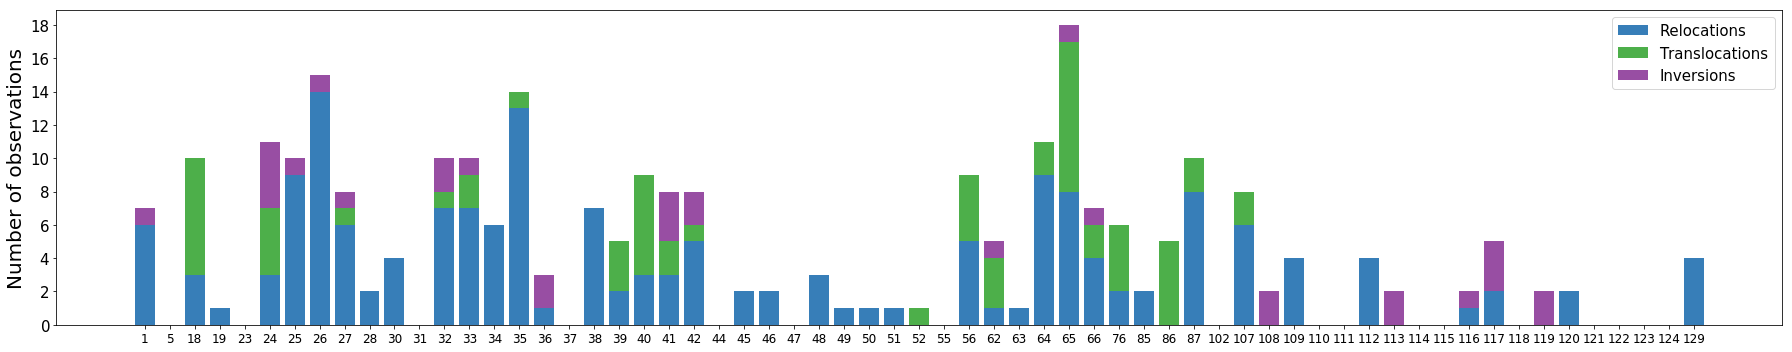

In [8]:
plt.figure(figsize = (25, 5))
pos = range(1, len(greedy_stats['num_misassemblies']) + 1)

rel_bar = greedy_stats['num_relocations']
trans_bar = greedy_stats['num_translocations']
inv_bar = greedy_stats['num_inversions']
plt.bar(pos, rel_bar, color = '#377eb8')
plt.bar(pos, trans_bar, bottom = rel_bar, color = '#4daf4a')
plt.bar(pos, inv_bar, bottom = np.array(rel_bar) + np.array(trans_bar), color = '#984ea3')


plt.xticks(range(1, len(greedy_stats['num_misassemblies']) + 1), greedy_stats['sample'], fontsize = 12);
plt.yticks(range(0, max(greedy_stats['num_misassemblies']) + 2, 2), fontsize = 15);
plt.ylabel('Number of observations', fontsize = 20);
plt.legend(['Relocations', 'Translocations', 'Inversions'], fontsize = 15)
plt.tight_layout()

plt.savefig('misassembly_counts_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_counts_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_counts_mob_filtered.png', format = 'png', dpi = 1200)

**Average number of misassembly events in 1000 nt of predicted plasmids per sample**

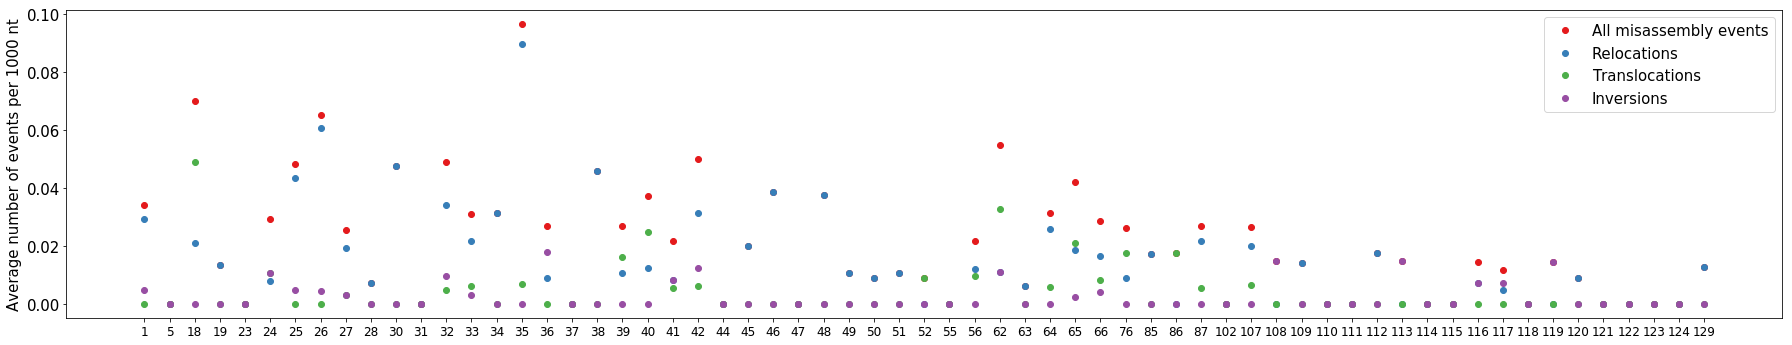

In [9]:
plt.figure(figsize = (25, 5))
pos = range(1, len(greedy_stats['num_misassemblies']) + 1)

plt.plot(pos, 1000 * np.array(greedy_stats['num_misassemblies']) / np.array(greedy_stats['prediction_length']), 'o', color = '#e41a1c')
plt.plot(pos, 1000 * np.array(greedy_stats['num_relocations']) / np.array(greedy_stats['prediction_length']), 'o', color = '#377eb8')
plt.plot(pos, 1000 * np.array(greedy_stats['num_translocations']) / np.array(greedy_stats['prediction_length']), 'o', color = '#4daf4a')
plt.plot(pos, 1000 * np.array(greedy_stats['num_inversions']) / np.array(greedy_stats['prediction_length']), 'o', color = '#984ea3')

plt.xticks(range(1, len(greedy_stats['num_misassemblies']) + 1), greedy_stats['sample'], fontsize = 12);
plt.yticks(fontsize = 15);
plt.ylabel('Average number of events per 1000 nt', fontsize = 15);
plt.legend(['All misassembly events', 'Relocations', 'Translocations', 'Inversions'], fontsize = 15)
plt.tight_layout()

plt.savefig('misassembly_rates_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_rates_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_rates_mob_filtered.png', format = 'png', dpi = 1200)

**Distributions of misassembly events**

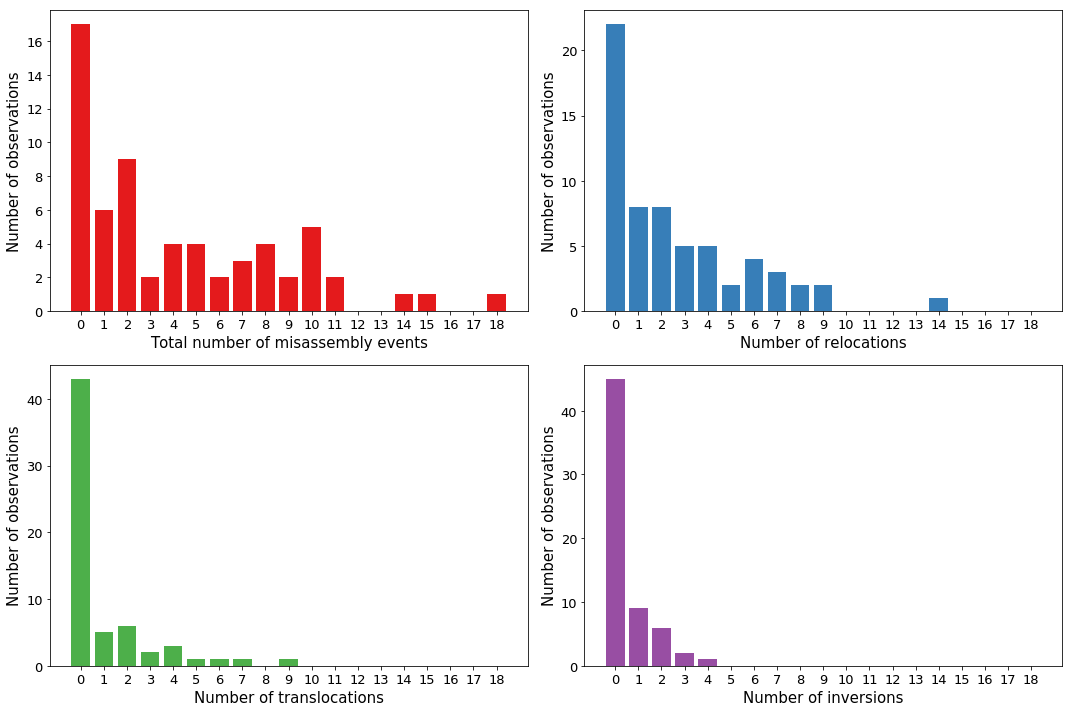

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
values = sorted(greedy_stats['num_misassemblies'].unique())

axes[0, 0].bar(values, [len(greedy_stats[greedy_stats['num_misassemblies'] == n]) for n in values], color = '#e41a1c')
axes[0, 0].set_xlabel('Total number of misassembly events', fontsize = 15)

axes[0, 1].bar(values, [len(greedy_stats[greedy_stats['num_relocations'] == n]) for n in values], color = '#377eb8')
axes[0, 1].set_xlabel('Number of relocations', fontsize = 15)

axes[1, 0].bar(values, [len(greedy_stats[greedy_stats['num_translocations'] == n]) for n in values], color = '#4daf4a')
axes[1, 0].set_xlabel('Number of translocations', fontsize = 15)

axes[1, 1].bar(values, [len(greedy_stats[greedy_stats['num_inversions'] == n]) for n in values], color = '#984ea3')
axes[1, 1].set_xlabel('Number of inversions', fontsize = 15)

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].set_ylabel('Number of observations', fontsize = 15)
        axes[i, j].set_xticks(range(values[0], values[-1] + 1))
        axes[i, j].tick_params(axis = 'x', labelsize = 13)
        axes[i, j].tick_params(axis = 'y', labelsize = 13)
plt.tight_layout()

plt.savefig('misassembly_hists_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('misassembly_hists_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('misassembly_hists_mob_filtered.png', format = 'png', dpi = 1200)

**Misassembly events vs. scores**

*Counts vs. scores*

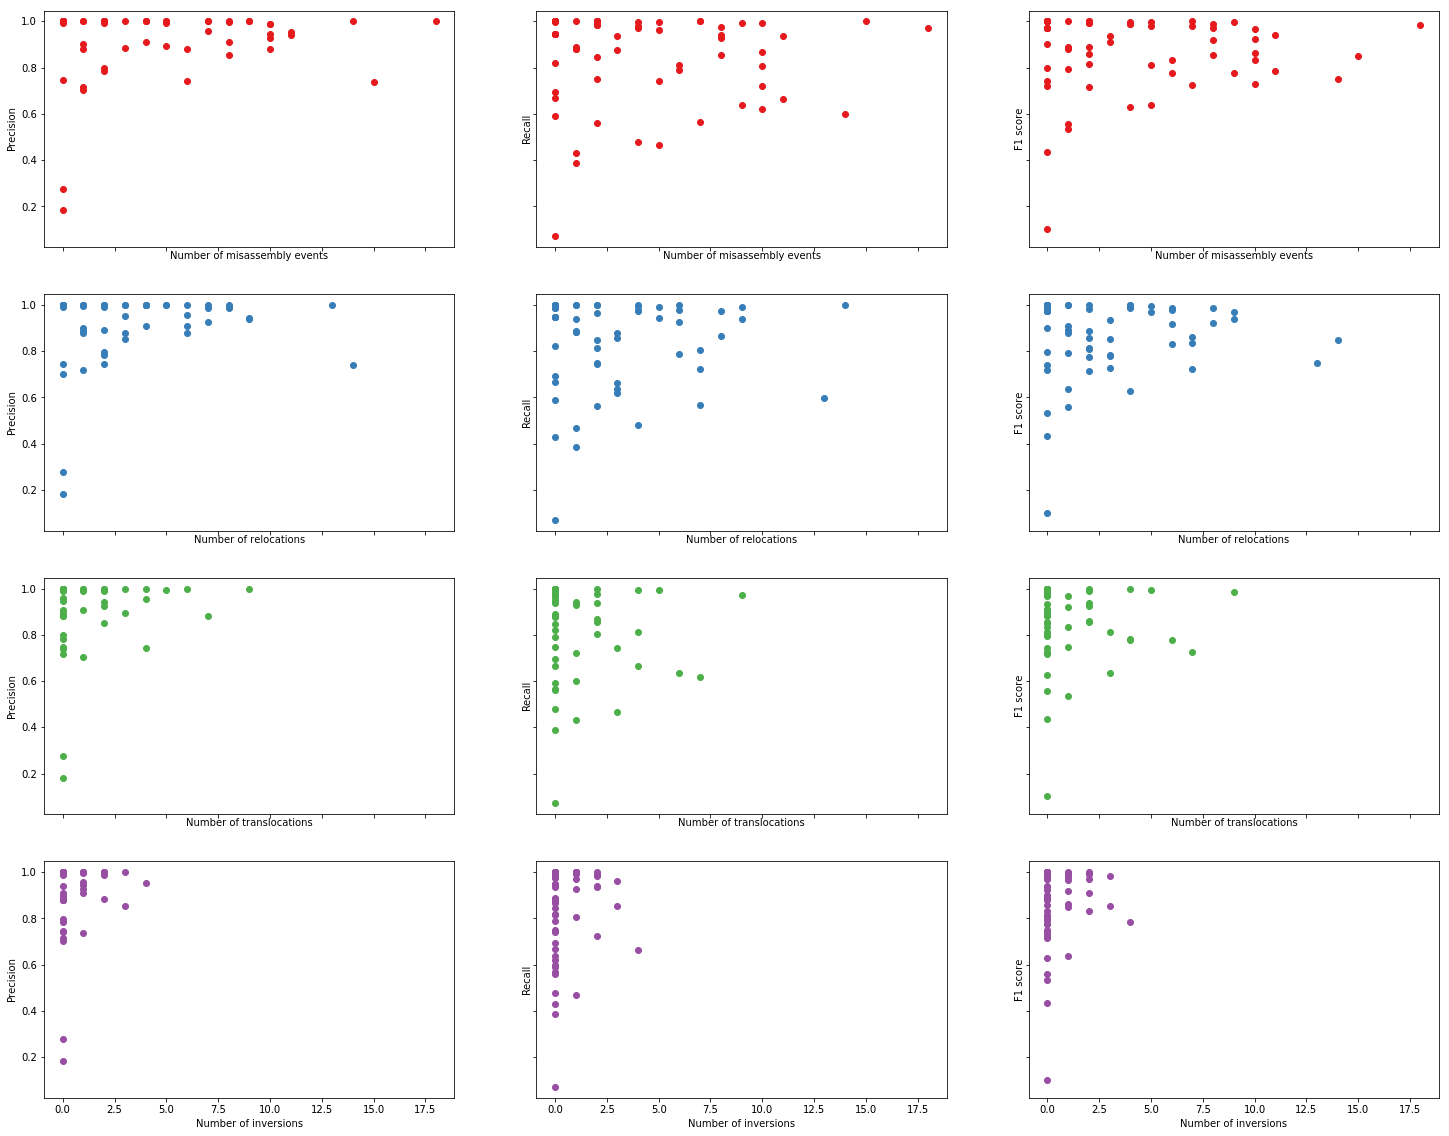

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20), sharex = True, sharey = True)

axes[0, 0].plot(greedy_stats['num_misassemblies'], greedy_stats['precision'], 'o', color = '#e41a1c')
axes[0, 1].plot(greedy_stats['num_misassemblies'], greedy_stats['recall'], 'o', color = '#e41a1c')
axes[0, 2].plot(greedy_stats['num_misassemblies'], greedy_stats['f1_score'], 'o', color = '#e41a1c')

axes[1, 0].plot(greedy_stats['num_relocations'], greedy_stats['precision'], 'o', color = '#377eb8')
axes[1, 1].plot(greedy_stats['num_relocations'], greedy_stats['recall'], 'o', color = '#377eb8')
axes[1, 2].plot(greedy_stats['num_relocations'], greedy_stats['f1_score'], 'o', color = '#377eb8')

axes[2, 0].plot(greedy_stats['num_translocations'], greedy_stats['precision'], 'o', color = '#4daf4a')
axes[2, 1].plot(greedy_stats['num_translocations'], greedy_stats['recall'], 'o', color = '#4daf4a')
axes[2, 2].plot(greedy_stats['num_translocations'], greedy_stats['f1_score'], 'o', color = '#4daf4a')

axes[3, 0].plot(greedy_stats['num_inversions'], greedy_stats['precision'], 'o', color = '#984ea3')
axes[3, 1].plot(greedy_stats['num_inversions'], greedy_stats['recall'], 'o', color = '#984ea3')
axes[3, 2].plot(greedy_stats['num_inversions'], greedy_stats['f1_score'], 'o', color = '#984ea3')

xlabs = ['Number of misassembly events', 'Number of relocations', 'Number of translocations', 'Number of inversions']
ylabs = ['Precision', 'Recall', 'F1 score']
for i in range(0, 4):
    for j in range(0, 3):
        axes[i, j].set_xlabel(xlabs[i])
        axes[i, j].set_ylabel(ylabs[j])

plt.show()

*Rates vs. scores*

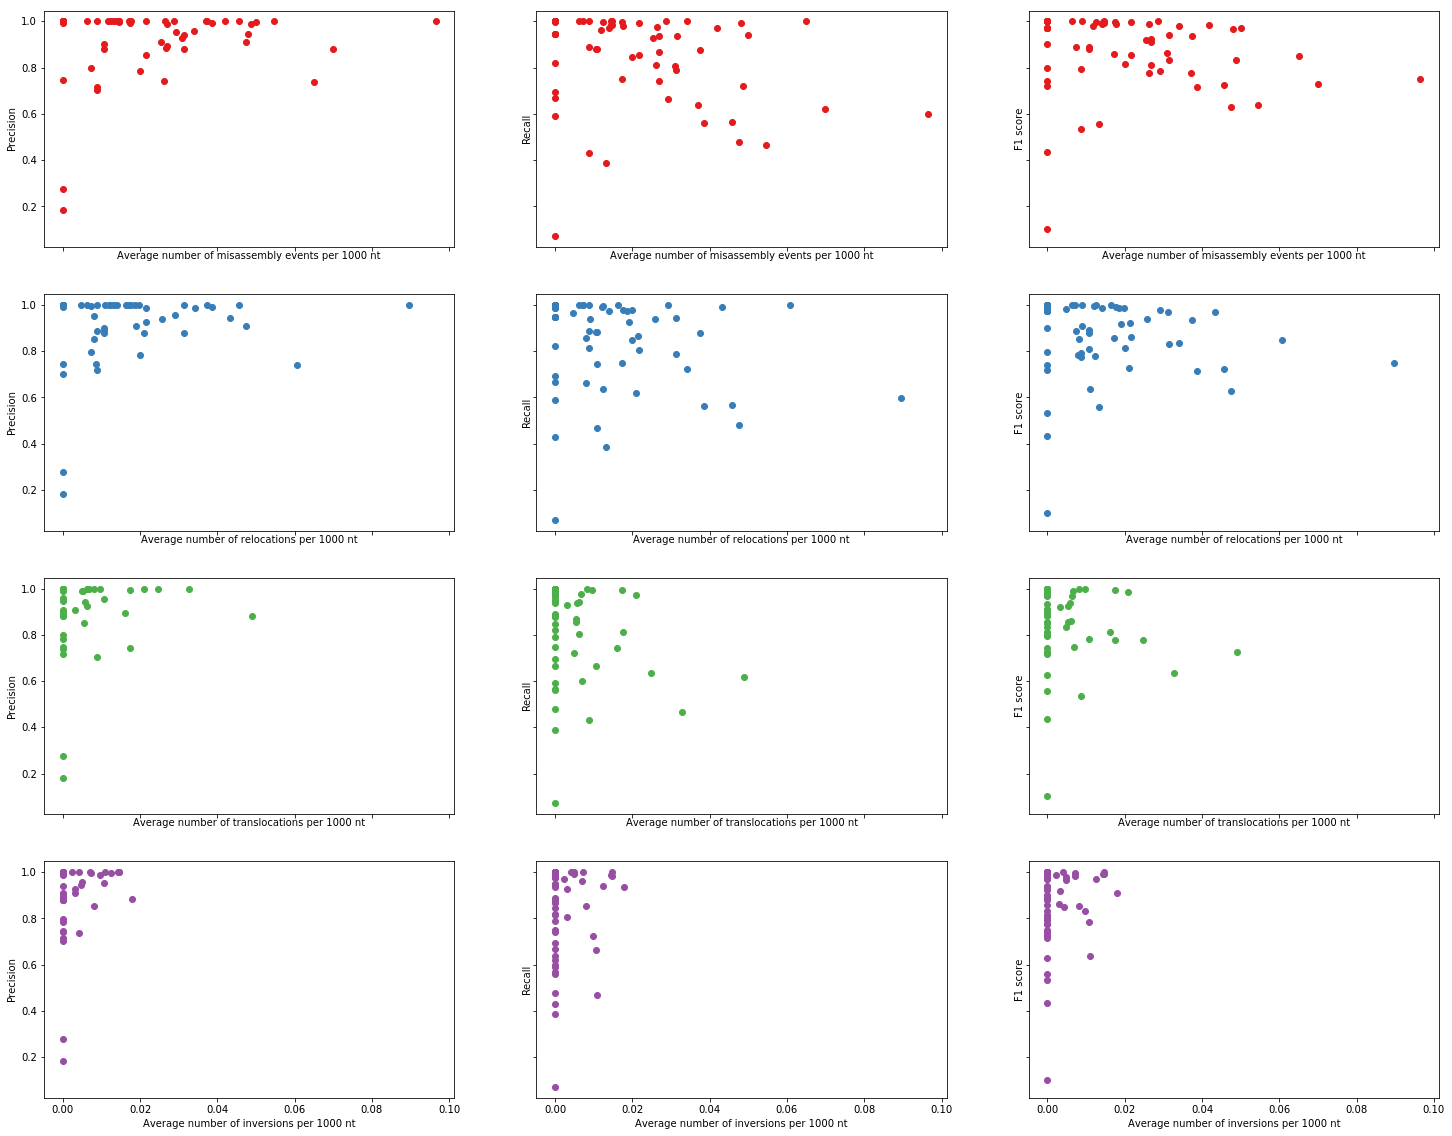

In [12]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20), sharex = True, sharey = True)

misasm_rates = 1000 * np.array(greedy_stats['num_misassemblies']) / np.array(greedy_stats['prediction_length'])
rel_rates = 1000 * np.array(greedy_stats['num_relocations']) / np.array(greedy_stats['prediction_length'])
trans_rates = 1000 * np.array(greedy_stats['num_translocations']) / np.array(greedy_stats['prediction_length'])
inv_rates = 1000 * np.array(greedy_stats['num_inversions']) / np.array(greedy_stats['prediction_length'])

axes[0, 0].plot(misasm_rates, greedy_stats['precision'], 'o', color = '#e41a1c')
axes[0, 1].plot(misasm_rates, greedy_stats['recall'], 'o', color = '#e41a1c')
axes[0, 2].plot(misasm_rates, greedy_stats['f1_score'], 'o', color = '#e41a1c')

axes[1, 0].plot(rel_rates, greedy_stats['precision'], 'o', color = '#377eb8')
axes[1, 1].plot(rel_rates, greedy_stats['recall'], 'o', color = '#377eb8')
axes[1, 2].plot(rel_rates, greedy_stats['f1_score'], 'o', color = '#377eb8')

axes[2, 0].plot(trans_rates, greedy_stats['precision'], 'o', color = '#4daf4a')
axes[2, 1].plot(trans_rates, greedy_stats['recall'], 'o', color = '#4daf4a')
axes[2, 2].plot(trans_rates, greedy_stats['f1_score'], 'o', color = '#4daf4a')

axes[3, 0].plot(inv_rates, greedy_stats['precision'], 'o', color = '#984ea3')
axes[3, 1].plot(inv_rates, greedy_stats['recall'], 'o', color = '#984ea3')
axes[3, 2].plot(inv_rates, greedy_stats['f1_score'], 'o', color = '#984ea3')

xlabs = ['Average number of misassembly events per 1000 nt', 'Average number of relocations per 1000 nt', 
         'Average number of translocations per 1000 nt', 'Average number of inversions per 1000 nt']
ylabs = ['Precision', 'Recall', 'F1 score']
for i in range(0, 4):
    for j in range(0, 3):
        axes[i, j].set_xlabel(xlabs[i])
        axes[i, j].set_ylabel(ylabs[j])

plt.show()